# Tarea 2

## Analisis de sentimiento de los comentarios de Youtube primer debate presidencial

In [3]:
#para poder instalar la API para descargar los commentarios de Youtube
#!pip install youtube-comment-downloader
#!pip install pandas as pd
#!pip install numpy as np
#!pip install textblob

Importamos los comentarios de Youtube directamente del video de interes, obteniendo la siguiente información Comentario_ID = cid, Comentario = text, Temporalidad del comentario = time, Nombre de usuario del comentador = author, Canal de comunicacion = channel, Numero de votos del comentario = votes, Numero de replicas del comentario = replies, imagen de perfil del usuario (URL) = photo, comment['heart'], comment['reply'], comment['time_parsed']

In [30]:
import csv
from itertools import islice
from youtube_comment_downloader import *

downloader = YoutubeCommentDownloader()
comments = downloader.get_comments_from_url('https://www.youtube.com/watch?v=kZaucITWv00&t=10s', sort_by=SORT_BY_POPULAR)

# Abre un archivo CSV en modo escritura
with open('comentarios.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["cid", "text", "time", "author", "channel", "votes", "replies", "photo", "heart", "reply", "time_parsed"])
    for comment in islice(comments, 4307): #4307
        writer.writerow([comment['cid'], comment['text'], comment['time'], comment['author'], comment['channel'], comment['votes'], comment['replies'], comment['photo'], comment['heart'], comment['reply'], comment['time_parsed']])

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split


In [31]:
df = pd.read_csv('comentarios.csv')

## Iniciamos preparando los datos que emplearemos para la estadistica ademas del texto

### pre procesado de datos

Adecaucuacion de la columna de votos, se combierten los valores no numericos a valores numericos

In [32]:
df['new_column'] = 1
df.loc[df['votes'].str.contains('K'), 'new_column'] = 1000
df['votes'] = df['votes'].str.replace('K', '')
df['votes'] = df['votes'].astype(float)
df['votes'] = df['votes'] * df['new_column']
df.drop(columns=['new_column'], inplace=True)
df['votes'] = df['votes'].replace(0, np.nan)
df['votes'] = df['votes'].replace(' ', np.nan)

## Analisis de sentimiento usando la herramienta TextBlob

In [33]:
# pip install -U textblob   ----
# python -m textblob.download_corpora

In [34]:
from textblob import TextBlob

Polaridad
-1 sentimiento muy negativo   0 sentimiento neutro   1 sentimiento positivo
subjetividad
0 muy objetivo   1  muy subjetivo


In [35]:
#  Para traducir comentarios en ingles
"""from textblob import TextBlob
df['textEs']=df['text'].apply(lambda x: TextBlob(x).translate(to='es'))
print(df['textEs'].head(9))
"""

"from textblob import TextBlob\ndf['textEs']=df['text'].apply(lambda x: TextBlob(x).translate(to='es'))\nprint(df['textEs'].head(9))\n"

In [36]:
df['polaridad']=df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subobj']=df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity) 
print(df['polaridad'].describe())
print(df['subobj'].describe())

count    1970.000000
mean       -0.001623
std         0.094901
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: polaridad, dtype: float64
count    1970.000000
mean        0.035070
std         0.163839
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: subobj, dtype: float64


C:\Users\juanj\AppData\Local\Temp\ipykernel_17344\1425618783.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-1, 10000)


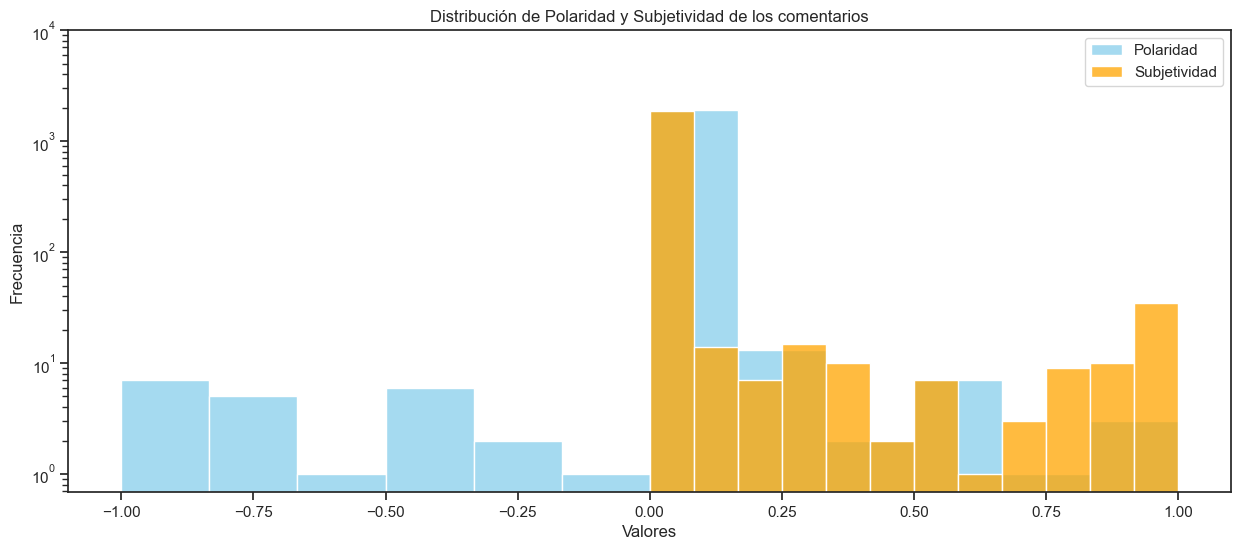

In [37]:
plt.figure(figsize=(15, 6))

sns.histplot(df['polaridad'], color='skyblue', label='Polaridad')
sns.histplot(df['subobj'], color='orange', label='Subjetividad')

plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.yscale('log')
plt.title('Distribución de Polaridad y Subjetividad de los comentarios')
plt.legend()
plt.ylim(-1, 10000)
plt.show()

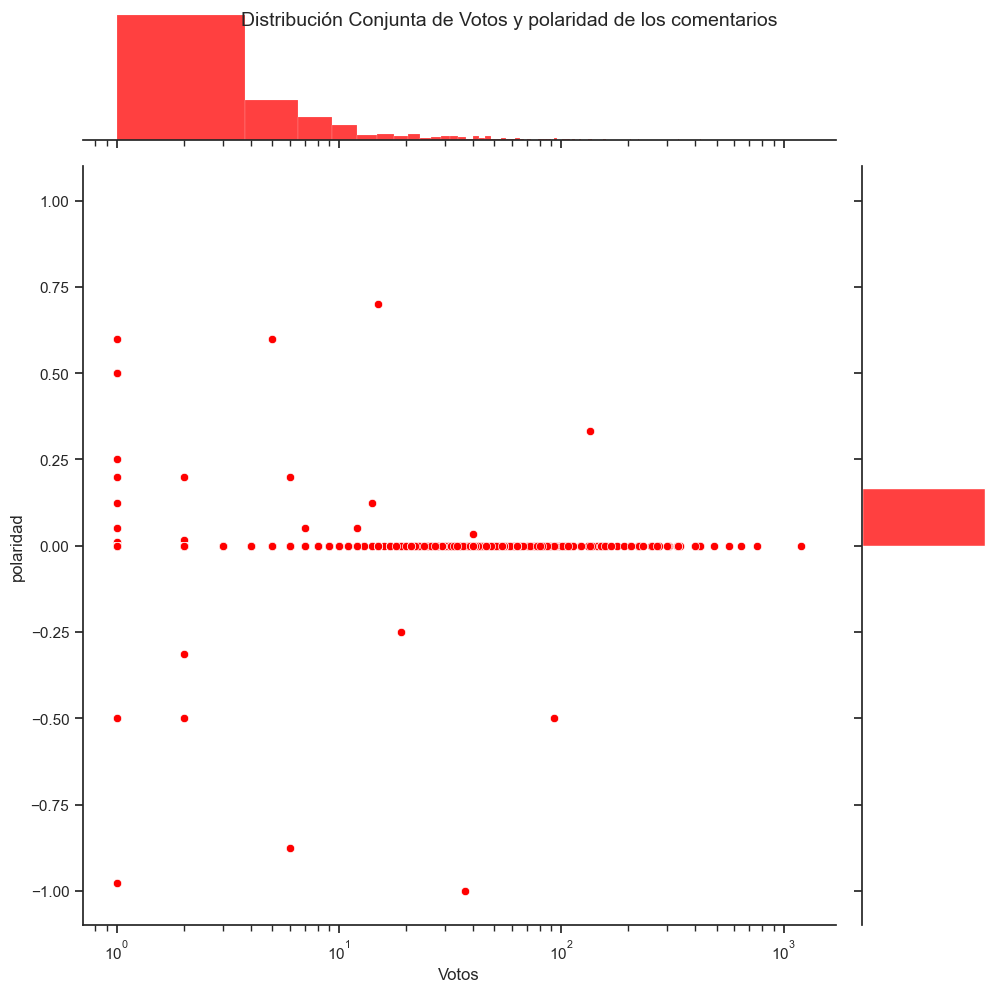

In [38]:
sns.set_theme(style="ticks")
g = sns.jointplot(x='votes', y='polaridad', data=df, kind='scatter', color='red', height=10)
g.set_axis_labels('Votos', 'polaridad')
g.fig.suptitle('Distribución Conjunta de Votos y polaridad de los comentarios', fontsize=14)

g.ax_joint.set_xscale('log')

plt.show()

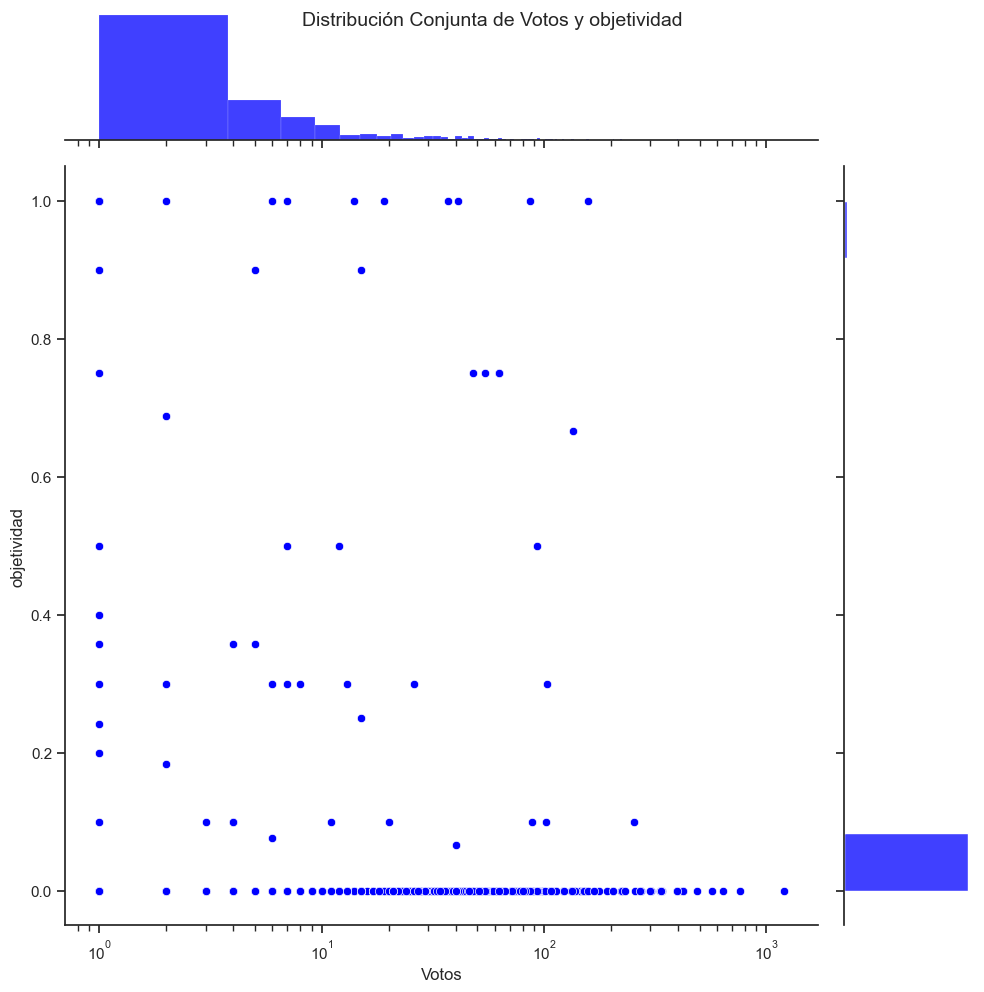

In [39]:
sns.set_theme(style="ticks")
g = sns.jointplot(x='votes', y='subobj', data=df, kind='scatter',color='blue', height=10)
g.set_axis_labels('Votos', 'objetividad')
g.fig.suptitle('Distribución Conjunta de Votos y objetividad', fontsize=14)

g.ax_joint.set_xscale('log')

plt.show()

In [40]:
df[0:3]

,cid,text,time,author,channel,votes,replies,photo,heart,reply,time_parsed,polaridad,subobj
0,UgwXfsDsPCIsH9OX2ep4AaABAg,Yo en la vida soy Maynez siempre sonriendo aun...,hace 2 meses,@missh03631,UC4-NYQLfeAc_sQA4pFfirCg,1200.0,42.0,https://yt3.ggpht.com/_FS5yWcGRa79uBIp38YcPE3d...,False,False,1.713639e+09,0.0,0.0
1,UgyC-sngHzjL9TgI7mt4AaABAg,Me uno a exigir que pongan los relojes de los ...,hace 2 meses,@puellacodicum8569,UC4SVihkvZdpk5wZota2sB3A,567.0,20.0,https://yt3.ggpht.com/ytc/AIdro_k8piN9LRX35zxX...,False,False,1.713639e+09,0.0,0.0
2,UgxLxZHrxYmRxBu90od4AaABAg,"Me parece muy bien cómo contestó Maynes, fue d...",hace 2 meses,@alondrareal8518,UCwrXDEdHaf4qoJk0GzUInJA,89.0,1.0,https://yt3.ggpht.com/ytc/AIdro_n2uIdu2oU52m0X...,False,False,1.713639e+09,0.0,0.0


### Procesamiento y clasificacion de datos

#### procesado de stop_words, emojis y tokenizacion

In [41]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Elimina emojis
df_cleaned = df.copy()
df_cleaned['text'] = df_cleaned['text'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)

# Carga las stopwords en español
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

df_cleaned['processed_text'] = df_cleaned['text'].apply(preprocess_text)

# Tokeniza
df_cleaned['tokens'] = df_cleaned['processed_text'].apply(word_tokenize)


<>:9: SyntaxWarning: invalid escape sequence '\w'
<>:9: SyntaxWarning: invalid escape sequence '\w'
C:\Users\juanj\AppData\Local\Temp\ipykernel_17344\4256233662.py:9: SyntaxWarning: invalid escape sequence '\w'
  df_cleaned['text'] = df_cleaned['text'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
df_cleaned = df_cleaned.drop(columns=['channel','cid','time', 'photo','heart', 'reply',	'time_parsed','author','processed_text' ])

#### Conteo de sentimiento

In [43]:
####### agragamos una columna que identifique el tipo de sentimiento expresado
df_cleaned['Sentimiento'] = df_cleaned['polaridad'].apply(lambda x: 'Neutral' if x == 0 else ('Positivo' if 0 < x <= 1 else 'Negativo'))

#### Conteo de subjetividad

In [44]:
df_cleaned['subjetividad'] = df_cleaned['subobj'].apply(lambda x: 'objetivo' if x == 0 else ('subjetivo' if 0 < x <= 1 else 'otro'))

#### Tokens y atributos

In [45]:
df_cleaned[0:5]

,text,votes,replies,polaridad,subobj,tokens,Sentimiento,subjetividad
0,Yo en la vida soy Maynez siempre sonriendo aun...,1200.0,42.0,0.0,0.0,"[vida, maynez, siempre, sonriendo, aunque, lle...",Neutral,objetivo
1,Me uno a exigir que pongan los relojes de los ...,567.0,20.0,0.0,0.0,"[exigir, pongan, relojes, 3, canditatos, tiemp...",Neutral,objetivo
2,"Me parece muy bien cómo contestó Maynes, fue d...",89.0,1.0,0.0,0.0,"[parece, bien, cómo, contestó, maynes, ,, dire...",Neutral,objetivo
3,Jajaja cuando le marcaron más tiempo para Xóch...,133.0,11.0,0.0,0.0,"[jajaja, marcaron, tiempo, xóchitl, realmente,...",Neutral,objetivo
4,"Cómo lo supuse , Xóchitl solo se dedicó a atac...",762.0,27.0,0.0,0.0,"[cómo, supuse, ,, xóchitl, solo, dedicó, ataca...",Neutral,objetivo


#### agregamos un identificador de numero de comentario

In [46]:
df_cleaned['NumCom'] = range(1, len(df_cleaned) + 1)

#### Realizamos conteo de palabras y promedio de palabras por clasificacion

In [47]:
df_cleaned['word_count'] = df_cleaned['text'].apply(lambda x: len(str(x).split()))
display(df_cleaned.head())

print(
    'Neutral',
    df_cleaned[df_cleaned['Sentimiento'] == 'Neutral']['word_count'].mean()
)
print(
    'Positivo',
    df_cleaned[df_cleaned['Sentimiento'] == 'Positivo']['word_count'].mean()
)
print(
    'Negativo',
    df_cleaned[df_cleaned['Sentimiento'] == 'Negativo']['word_count'].mean()
)  
print(
    'objetivo',
    df_cleaned[df_cleaned['subjetividad'] == 'objetivo']['word_count'].mean()
)  
print(
    'subjetivo',
    df_cleaned[df_cleaned['subjetividad'] == 'subjetivo']['word_count'].mean()
)  

,text,votes,replies,polaridad,subobj,tokens,Sentimiento,subjetividad,NumCom,word_count
0,Yo en la vida soy Maynez siempre sonriendo aun...,1200.0,42.0,0.0,0.0,"[vida, maynez, siempre, sonriendo, aunque, lle...",Neutral,objetivo,1,14
1,Me uno a exigir que pongan los relojes de los ...,567.0,20.0,0.0,0.0,"[exigir, pongan, relojes, 3, canditatos, tiemp...",Neutral,objetivo,2,19
2,"Me parece muy bien cómo contestó Maynes, fue d...",89.0,1.0,0.0,0.0,"[parece, bien, cómo, contestó, maynes, ,, dire...",Neutral,objetivo,3,18
3,Jajaja cuando le marcaron más tiempo para Xóch...,133.0,11.0,0.0,0.0,"[jajaja, marcaron, tiempo, xóchitl, realmente,...",Neutral,objetivo,4,28
4,"Cómo lo supuse , Xóchitl solo se dedicó a atac...",762.0,27.0,0.0,0.0,"[cómo, supuse, ,, xóchitl, solo, dedicó, ataca...",Neutral,objetivo,5,23


Neutral 17.86740041928721
Positivo 50.1
Negativo 49.22727272727273
objetivo 16.94495412844037
subjetivo 49.39316239316239


C:\Users\juanj\AppData\Local\Temp\ipykernel_17344\3853259577.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Categoría', y='Media de palabras', data=data, palette='viridis')


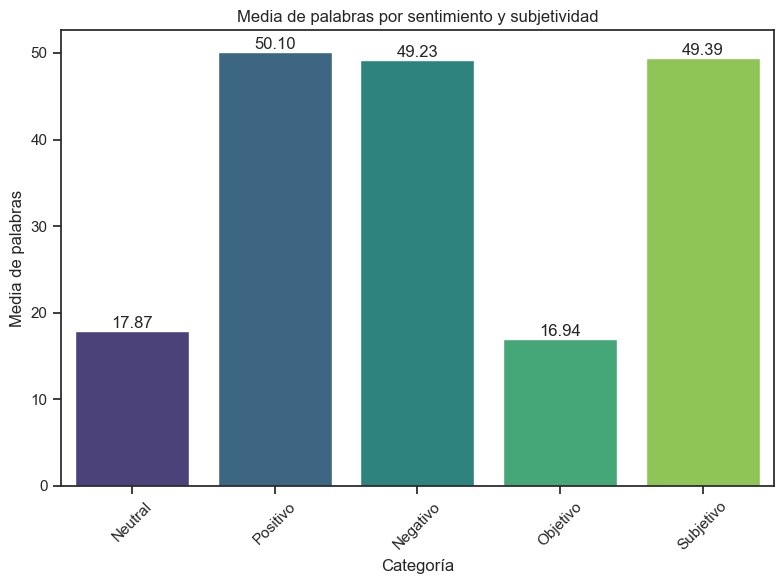

In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que ya tienes un DataFrame llamado df_cleaned con la columna 'word_count'

# Calcular las medias de palabras
mean_neutral = df_cleaned[df_cleaned['Sentimiento'] == 'Neutral']['word_count'].mean()
mean_positivo = df_cleaned[df_cleaned['Sentimiento'] == 'Positivo']['word_count'].mean()
mean_negativo = df_cleaned[df_cleaned['Sentimiento'] == 'Negativo']['word_count'].mean()
mean_objetivo = df_cleaned[df_cleaned['subjetividad'] == 'objetivo']['word_count'].mean()
mean_subjetivo = df_cleaned[df_cleaned['subjetividad'] == 'subjetivo']['word_count'].mean()

# Crear un DataFrame con los valores
data = pd.DataFrame({
    'Categoría': ['Neutral', 'Positivo', 'Negativo', 'Objetivo', 'Subjetivo'],
    'Media de palabras': [mean_neutral, mean_positivo, mean_negativo, mean_objetivo, mean_subjetivo]
})

# Crear la gráfica de barras
plt.figure(figsize=(8, 6))
sns.barplot(x='Categoría', y='Media de palabras', data=data, palette='viridis')
plt.title('Media de palabras por sentimiento y subjetividad')
plt.xlabel('Categoría')
plt.ylabel('Media de palabras')
plt.xticks(rotation=45)
plt.tight_layout()

# Agregar los valores en la parte superior de las barras
for index, row in data.iterrows():
    plt.annotate(f"{row['Media de palabras']:.2f}", xy=(index, row['Media de palabras']), ha='center', va='bottom')

# Mostrar la gráfica
plt.show()


#### conteo de caracteres

In [48]:
df_cleaned['char_count'] = df_cleaned['text'].apply(lambda x: len(str(x)))
display(df_cleaned.head())

print(
    'Neutral',
    df_cleaned[df_cleaned['Sentimiento'] == 'Neutral']['char_count'].mean()
)
print(
    'Positivo',
    df_cleaned[df_cleaned['Sentimiento'] == 'Positivo']['char_count'].mean()
)
print(
    'Negativo',
    df_cleaned[df_cleaned['Sentimiento'] == 'Negativo']['char_count'].mean()
)  
print(
    'objetivo',
    df_cleaned[df_cleaned['subjetividad'] == 'objetivo']['char_count'].mean()
)  
print(
    'subjetivo',
    df_cleaned[df_cleaned['subjetividad'] == 'subjetivo']['char_count'].mean()
) 

,text,votes,replies,polaridad,subobj,tokens,Sentimiento,subjetividad,NumCom,word_count,char_count
0,Yo en la vida soy Maynez siempre sonriendo aun...,1200.0,42.0,0.0,0.0,"[vida, maynez, siempre, sonriendo, aunque, lle...",Neutral,objetivo,1,14,74
1,Me uno a exigir que pongan los relojes de los ...,567.0,20.0,0.0,0.0,"[exigir, pongan, relojes, 3, canditatos, tiemp...",Neutral,objetivo,2,19,107
2,"Me parece muy bien cómo contestó Maynes, fue d...",89.0,1.0,0.0,0.0,"[parece, bien, cómo, contestó, maynes, ,, dire...",Neutral,objetivo,3,18,113
3,Jajaja cuando le marcaron más tiempo para Xóch...,133.0,11.0,0.0,0.0,"[jajaja, marcaron, tiempo, xóchitl, realmente,...",Neutral,objetivo,4,28,172
4,"Cómo lo supuse , Xóchitl solo se dedicó a atac...",762.0,27.0,0.0,0.0,"[cómo, supuse, ,, xóchitl, solo, dedicó, ataca...",Neutral,objetivo,5,23,114


Neutral 101.77777777777777
Positivo 291.575
Negativo 280.27272727272725
objetivo 96.51969778737183
subjetivo 283.5042735042735


C:\Users\juanj\AppData\Local\Temp\ipykernel_17344\2237532106.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Categoría', y='Media de caracteres', data=data, palette='viridis')


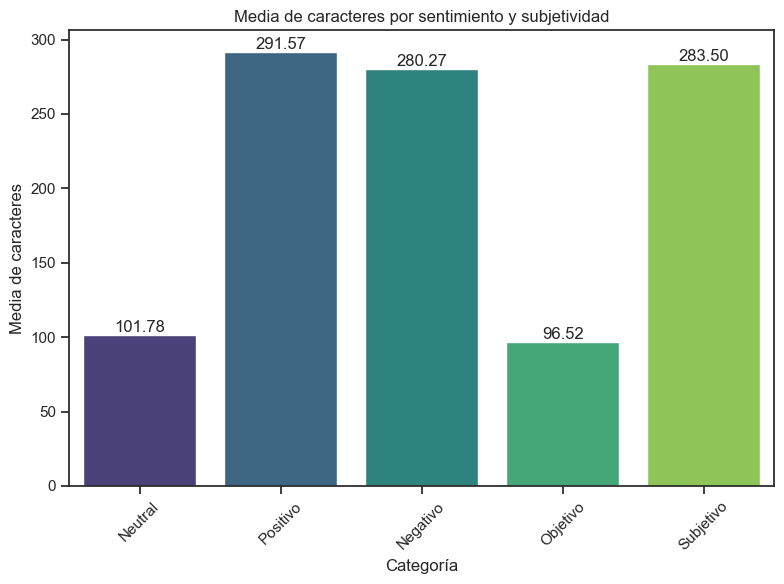

In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que ya tienes un DataFrame llamado df_cleaned con la columna 'char_count'

# Calcular las medias de caracteres
mean_neutral = df_cleaned[df_cleaned['Sentimiento'] == 'Neutral']['char_count'].mean()
mean_positivo = df_cleaned[df_cleaned['Sentimiento'] == 'Positivo']['char_count'].mean()
mean_negativo = df_cleaned[df_cleaned['Sentimiento'] == 'Negativo']['char_count'].mean()
mean_objetivo = df_cleaned[df_cleaned['subjetividad'] == 'objetivo']['char_count'].mean()
mean_subjetivo = df_cleaned[df_cleaned['subjetividad'] == 'subjetivo']['char_count'].mean()

# Crear un DataFrame con los valores
data = pd.DataFrame({
    'Categoría': ['Neutral', 'Positivo', 'Negativo', 'Objetivo', 'Subjetivo'],
    'Media de caracteres': [mean_neutral, mean_positivo, mean_negativo, mean_objetivo, mean_subjetivo]
})

# Crear la gráfica de barras
plt.figure(figsize=(8, 6))
sns.barplot(x='Categoría', y='Media de caracteres', data=data, palette='viridis')
plt.title('Media de caracteres por sentimiento y subjetividad')
plt.xlabel('Categoría')
plt.ylabel('Media de caracteres')
plt.xticks(rotation=45)
plt.tight_layout()

# Agregar los valores en la parte superior de las barras
for index, row in data.iterrows():
    plt.annotate(f"{row['Media de caracteres']:.2f}", xy=(index, row['Media de caracteres']), ha='center', va='bottom')

# Mostrar la gráfica
plt.show()


#### Densidad de palabras

In [49]:
df_cleaned['word_density'] = df_cleaned['char_count'] / df_cleaned['word_count']
df_cleaned.head()

,text,votes,replies,polaridad,subobj,tokens,Sentimiento,subjetividad,NumCom,word_count,char_count,word_density
0,Yo en la vida soy Maynez siempre sonriendo aun...,1200.0,42.0,0.0,0.0,"[vida, maynez, siempre, sonriendo, aunque, lle...",Neutral,objetivo,1,14,74,5.285714
1,Me uno a exigir que pongan los relojes de los ...,567.0,20.0,0.0,0.0,"[exigir, pongan, relojes, 3, canditatos, tiemp...",Neutral,objetivo,2,19,107,5.631579
2,"Me parece muy bien cómo contestó Maynes, fue d...",89.0,1.0,0.0,0.0,"[parece, bien, cómo, contestó, maynes, ,, dire...",Neutral,objetivo,3,18,113,6.277778
3,Jajaja cuando le marcaron más tiempo para Xóch...,133.0,11.0,0.0,0.0,"[jajaja, marcaron, tiempo, xóchitl, realmente,...",Neutral,objetivo,4,28,172,6.142857
4,"Cómo lo supuse , Xóchitl solo se dedicó a atac...",762.0,27.0,0.0,0.0,"[cómo, supuse, ,, xóchitl, solo, dedicó, ataca...",Neutral,objetivo,5,23,114,4.956522


In [50]:
df_cleaned = df_cleaned

<Axes: xlabel='Sentimiento'>

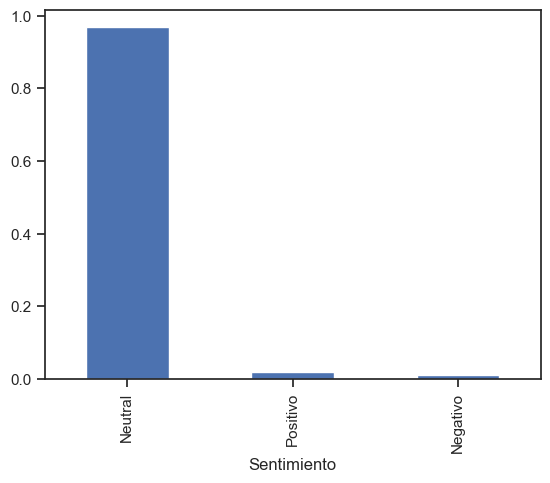

In [51]:
df_cleaned['Sentimiento'].value_counts(normalize = True).plot.bar()

<Axes: xlabel='replies'>

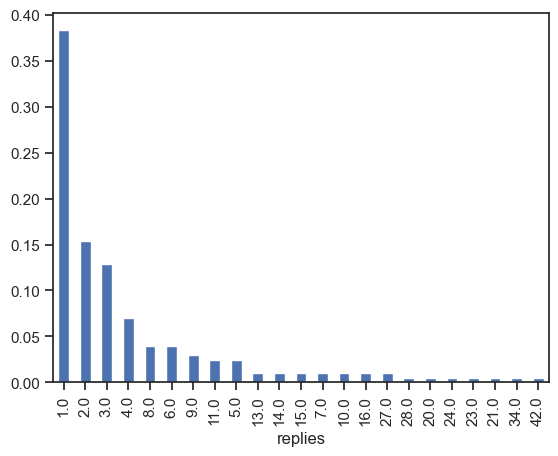

In [52]:
df_cleaned['replies'].value_counts(normalize = True).plot.bar()

<Axes: xlabel='subjetividad'>

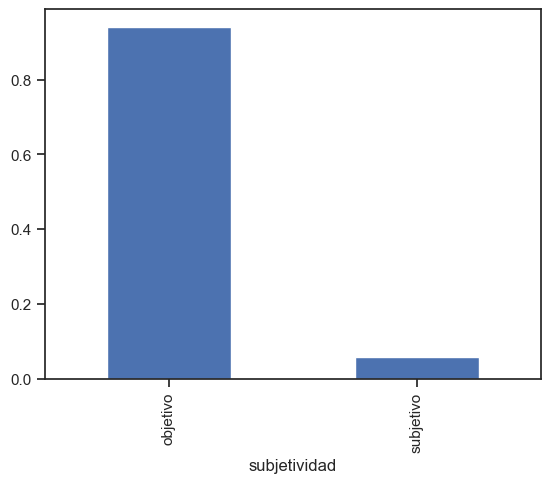

In [53]:
df_cleaned['subjetividad'].value_counts(normalize = True).plot.bar()

In [54]:
df_Neutral = df_cleaned[df_cleaned['Sentimiento'] == 'Neutral']
df_Positivo = df_cleaned[df_cleaned['Sentimiento'] == 'Positivo']
df_Negativo = df_cleaned[df_cleaned['Sentimiento'] == 'Negativo']
df_objetivo = df_cleaned[df_cleaned['subjetividad'] == 'objetivo']
df_subjetivo = df_cleaned[df_cleaned['subjetividad'] == 'subjetivo']

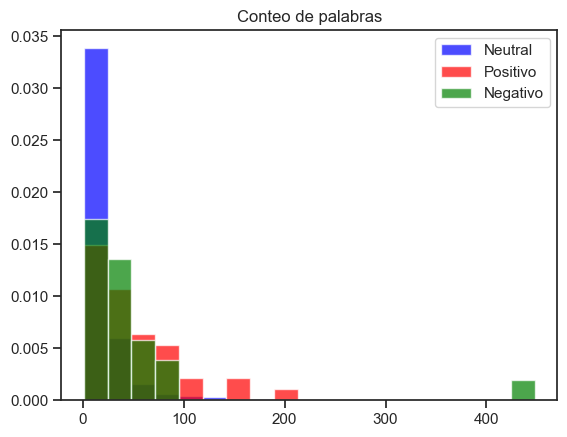

In [104]:
plt.figure()
plt.title('Conteo de palabras')
bins = np.linspace(np.min(df_cleaned['word_count']), np.max(df_cleaned['word_count']), 20)

plt.hist(df_Neutral['word_count'],  label = 'Neutral', bins = bins, color = 'blue', alpha = 0.7, density = True)
plt.hist(df_Positivo['word_count'],  label = 'Positivo', bins = bins, color = 'red', alpha = 0.7, density = True)
plt.hist(df_Negativo['word_count'],  label = 'Negativo', bins = bins, color = 'green', alpha = 0.7, density = True)
plt.legend()
plt.show()

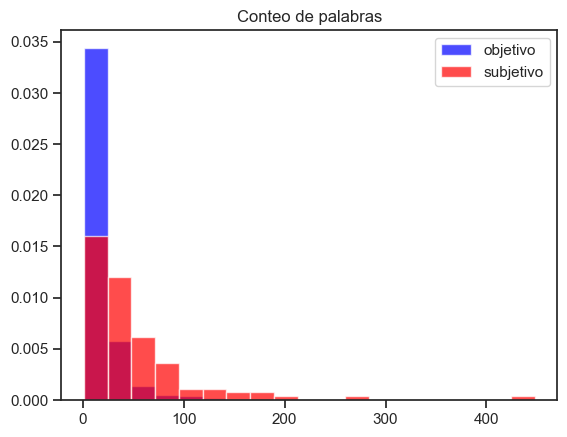

In [105]:
plt.figure()
plt.title('Conteo de palabras')
bins = np.linspace(np.min(df_cleaned['word_count']), np.max(df_cleaned['word_count']), 20)

plt.hist(df_objetivo['word_count'],  label = 'objetivo', bins = bins, color = 'blue', alpha = 0.7, density = True)
plt.hist(df_subjetivo['word_count'],  label = 'subjetivo', bins = bins, color = 'red', alpha = 0.7, density = True)
plt.legend()
plt.show()

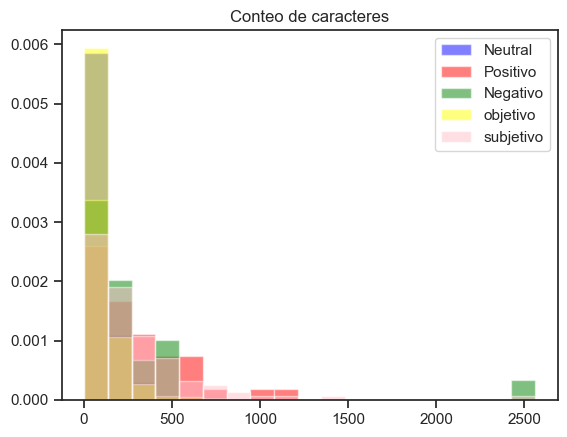

In [56]:
plt.figure()
plt.title('Conteo de caracteres')
bins = np.linspace(np.min(df_cleaned['char_count']), np.max(df_cleaned['char_count']), 20)

plt.hist(df_Neutral['char_count'],  label = 'Neutral', bins = bins, color = 'blue', alpha = 0.5, density = True)
plt.hist(df_Positivo['char_count'],  label = 'Positivo', bins = bins, color = 'red', alpha = 0.5, density = True)
plt.hist(df_Negativo['char_count'],  label = 'Negativo', bins = bins, color = 'green', alpha = 0.5, density = True)
plt.hist(df_objetivo['char_count'],  label = 'objetivo', bins = bins, color = 'yellow', alpha = 0.5, density = True)
plt.hist(df_subjetivo['char_count'],  label = 'subjetivo', bins = bins, color = 'pink', alpha = 0.5, density = True)
plt.legend()
plt.show()

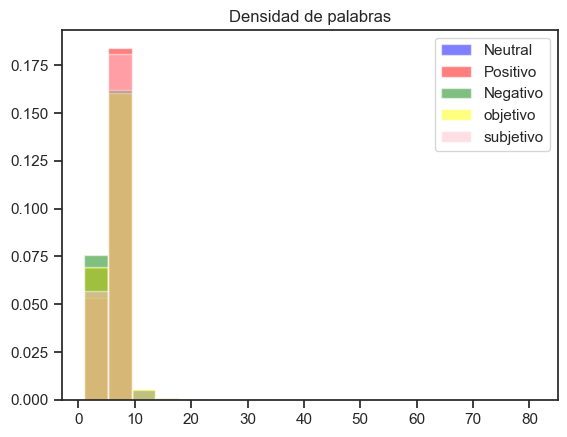

In [57]:
plt.figure()
plt.title('Densidad de palabras')
bins = np.linspace(np.min(df_cleaned['word_density']), np.max(df_cleaned['word_density']), 20)

plt.hist(df_Neutral['word_density'],  label = 'Neutral', bins = bins, color = 'blue', alpha = 0.5, density = True)
plt.hist(df_Positivo['word_density'],  label = 'Positivo', bins = bins, color = 'red', alpha = 0.5, density = True)
plt.hist(df_Negativo['word_density'],  label = 'Negativo', bins = bins, color = 'green', alpha = 0.5, density = True)
plt.hist(df_objetivo['word_density'],  label = 'objetivo', bins = bins, color = 'yellow', alpha = 0.5, density = True)
plt.hist(df_subjetivo['word_density'],  label = 'subjetivo', bins = bins, color = 'pink', alpha = 0.5, density = True)
plt.legend()
plt.show()

#### Entrenamiento de prediccion de sentimiento

#### preparacion del texto

In [58]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\juanj\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\juanj\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\juanj\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\juanj\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\juanj\AppData\Roaming\nltk_data...
[

True

In [76]:
text = list(df_cleaned['text'])

In [77]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

corpus = []

In [78]:
for i in range(len(text)):
    r = re.sub('[^a-zA-Z]', ' ', text[i])
    r = r.lower()
    r = r.split()
    r = [word for word in r if word not in stopwords.words('spanish')]
    r = [lemmatizer.lemmatize(word) for word in r]
    r = ' '.join(r)
    corpus.append(r)

In [79]:
df_cleaned['text_clean'] = corpus
df_cleaned.head()

,text,votes,replies,polaridad,subobj,tokens,Sentimiento,subjetividad,NumCom,word_count,char_count,word_density,text_clean
0,Yo en la vida soy Maynez siempre sonriendo aun...,1200.0,42.0,0.0,0.0,"[vida, maynez, siempre, sonriendo, aunque, lle...",Neutral,objetivo,1,14,74,5.285714,vida maynez siempre sonriendo aunque est lleva...
1,Me uno a exigir que pongan los relojes de los ...,567.0,20.0,0.0,0.0,"[exigir, pongan, relojes, 3, canditatos, tiemp...",Neutral,objetivo,2,19,107,5.631579,exigir pongan relojes canditatos tiempo deber ...
2,"Me parece muy bien cómo contestó Maynes, fue d...",89.0,1.0,0.0,0.0,"[parece, bien, cómo, contestó, maynes, ,, dire...",Neutral,objetivo,3,18,113,6.277778,parece bien c mo contest maynes directo pregun...
3,Jajaja cuando le marcaron más tiempo para Xóch...,133.0,11.0,0.0,0.0,"[jajaja, marcaron, tiempo, xóchitl, realmente,...",Neutral,objetivo,4,28,172,6.142857,jajaja marcaron m s tiempo x chitl realmente t...
4,"Cómo lo supuse , Xóchitl solo se dedicó a atac...",762.0,27.0,0.0,0.0,"[cómo, supuse, ,, xóchitl, solo, dedicó, ataca...",Neutral,objetivo,5,23,114,4.956522,c mo supuse x chitl solo dedic atacar claudia ...


#### Entrenamiento y prueba

In [80]:
# Create Feature and Label sets
X = df_cleaned['text_clean']
y = df_cleaned['Sentimiento']

# train test split (80% train - 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

print('Training Data :', X_train.shape)
print('Testing Data : ', X_test.shape)

Training Data : (985,)
Testing Data :  (985,)


In [81]:
X_train

893                              luisfersx vato dan apoyo
437                                      ine mandarlo alv
1788         quitan tiempo claudia mientras habla xochitl
807                 desverguenza ine colores subliminales
1295    jjajajjaajjjajajaajja aguila pa abajo jajajajj...
                              ...                        
1690      preguntas ine mal intencionadas gobierno actual
19      pongan reloj pantalla pueblo tonto subestimen ...
1174                    si quieres saber lee constituci n
888     user c amlonarcopresidente puso pa s cabeza en...
1105                  hagan meme xochitl empapelada favor
Name: text_clean, Length: 985, dtype: object

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [83]:
# conteo de palabras
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(X_train)
xtrain_count =  count_vect.transform(X_train)
xtest_count =  count_vect.transform(X_test)

# palabras
tfidf_vect = TfidfVectorizer(analyzer='word')
xtrain_tfidf =  tfidf_vect.fit_transform(X_train)
xtest_tfidf =  tfidf_vect.transform(X_test)

# ngramas
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', ngram_range=(2,3))
xtrain_tfidf_ngram =  tfidf_vect_ngram.fit_transform(X_train)
xtest_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

# caracteres
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char')
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.fit_transform(X_train)
xtest_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(X_test)

#### Modelo

In [84]:
from sklearn.linear_model import LogisticRegression

import pandas as pd
from sklearn import metrics

In [85]:
lr = LogisticRegression()
lr.fit(xtrain_count, y_train)

# generate predictions
predictions = lr.predict(xtest_count)

In [86]:
df_confusion = pd.DataFrame(metrics.confusion_matrix(y_test, predictions), index=['Neutral','Positivo','Negativo'], columns=['Neutral','Positivo','Negativo'])
df_confusion

,Neutral,Positivo,Negativo
Neutral,0,12,0
Positivo,0,949,0
Negativo,0,24,0


In [87]:
pares = [
    ('conteo', xtrain_count, xtest_count),
    ('palabras', xtrain_tfidf, xtest_tfidf),
    ('ngramas', xtrain_tfidf_ngram, xtest_tfidf_ngram),
    ('caracteres', xtrain_tfidf_ngram_chars, xtest_tfidf_ngram_chars)
]

for datos in pares:
    lr.fit(datos[1], y_train)
    predictions = lr.predict(datos[2])
    df_confusion = pd.DataFrame(metrics.confusion_matrix(y_test, predictions), index=['Neutral','Positivo','Negativo'], columns=['Neutral','Positivo','Negativo'])
    print(datos[0], '\n', df_confusion, '\n')


conteo 
           Neutral  Positivo  Negativo
Neutral         0        12         0
Positivo        0       949         0
Negativo        0        24         0 

palabras 
           Neutral  Positivo  Negativo
Neutral         0        12         0
Positivo        0       949         0
Negativo        0        24         0 

ngramas 
           Neutral  Positivo  Negativo
Neutral         0        12         0
Positivo        0       949         0
Negativo        0        24         0 

caracteres 
           Neutral  Positivo  Negativo
Neutral         0        12         0
Positivo        0       949         0
Negativo        0        24         0 



In [88]:
#df_tokens_cap = df_cleaned.explode(column='tokens')
#df_tokens_cap

In [89]:
# Frecuencia de palabras por comentario
#plt.figure()
#df_tokens_cap.groupby(by='NumCom')['tokens'].count().plot(kind= 'barh', figsize=(10, 300))
#plt.gca().invert_yaxis()
#plt.show()

In [90]:
# Ordenadas por conteo
#pd_caps_freq_ord = pd.DataFrame(df_tokens_cap.groupby(by='NumCom')['tokens'].count()).reset_index().sort_values('tokens').set_index('NumCom')
#pd_caps_freq_ord.columns = ['frecuencia']
#plt.figure()
#pd_caps_freq_ord.plot(kind= 'barh', figsize=(10, 300))
#plt.gca().invert_yaxis()
#plt.show()


In [91]:
# Palabras más utilizadas por capítulo
#df_tokens_cap.groupby(['NumCom','tokens'])['tokens'].count().reset_index(name='conteo').sort_values(['NumCom', 'conteo'], ascending=[True, False])

#### busqueda de usuarios

In [92]:
fila_juan1 = df_comentarios.loc[df_comentarios['NumCom'] == 6]
print(fila_juan1['text'])
fila_juan2 = df_comentarios.loc[df_comentarios['NumCom'] == 8]
print(fila_juan2['text'])


NameError: name 'df_comentarios' is not defined